# Soft Actor Critic Agent(115 Points)

> Name:Mohammad Kalbasi

> SID: 401211028



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




used refrences:

https://github.com/aviralkumar2907/CQL

https://github.com/haarnoja/sac

https://github.com/young-geng/CQL/blob/master/SimpleSAC/sac.py

https://github.com/BY571/CQL/blob/main/CQL-SAC/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [ ]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        hidden_layer_size = 64 # we assume that all hidden layer have same amount of nodes
        self.output_dimension = output_dimension
        self.input_dimension = input_dimension
        self.output_activation = output_activation
        self.input_layer = nn.Linear(input_dimension,hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size,hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size,output_dimension)

        ##########################################################
        pass
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        x = F.relu(self.input_layer(inpt))
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        output = self.output_activation(x)

        # Use relu and the output activation functions to calculate the output
        ##########################################################
        return output
        ##########################################################

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [ ]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**(-2)
        self.delta = 10**(-4)
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.



In SAC, additional to maximizing sample rewards it also seek to maximum policy entropy, so this way it allows policy to capture multiple modes of near-optimal behavior, bellow you can see our objective funciton:(based on lecture slides)
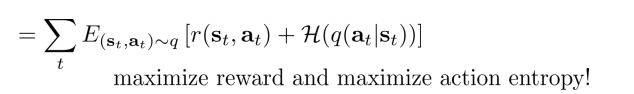

❓ Write down the actor cost function.

for actor in general we have:
$$ argmin(Dkl(\pi(.|s),\frac{1}{z}exp(Q(s,.))) $$
so when getting logarithm and scaling with alpha we can simply learn:

$$ \alpha Log(\pi(a|s)) - Q(s,a)$$

❓ Write down the critic cost function.

simple form for cost function is:
<br/>
<br/>

$$ Q(s,a) \gets r(s,a) + E_s,_a[Q(s',a') - log(\pi(a'|s'))]$$

but when we add discount factor and a multiplyer to weight entropy differently we achive :

$$ Q(s,a) \gets r(s,a) + \gamma(Q(s',a')) - \alpha(log(\pi(a'|s')))$$

so we just need to calculate mse loss between Q and $$r(s,a) + \gamma E[(Q(s',a')) - \alpha(log(\pi(a'|s')))]$$ and update Q function according to it.because we dealing with discrete setting and only have two actions, we can easily calculate E part by multiplying probability of each action in said term.

❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).

SAC uses two critics to address the issue of overestimation bias that is common in Q-learning methods. Overestimation bias occurs when the Q-function gives an overinflated estimate of the expected return for a given state-action pair. This can lead to suboptimal behavior as the policy is updated too optimistically. To mitigate this issue, SAC uses two Q-functions and takes the minimum of their estimates when computing the policy update and the target value. This helps to control overestimation bias and improve stability during training.



❓ What is the difference between training samples in offline and online settings?

in offline setting, we already have our data and we dont have access to system (during training phase) so when training policy, we dont get a feedback from system to see if we are overstimating action values or not, but in online  training after each policy update, we run policy again and gather more data and update policy based on this new data.

❓ How does adding CQL on top of SAC change the objective function?

we can see main CQL objective for standard Q learning here:



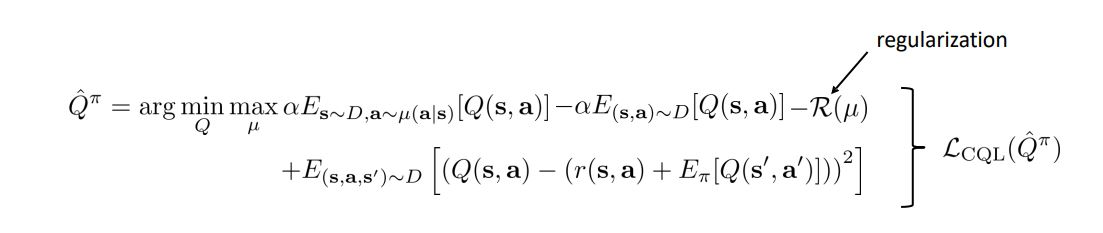

so lcq term is only first three terms (until end of reguralization term), it can be show that if we choose regularization term be maximizng Q entropy, the final objective can be written:
$$ Q \leftarrow argmin[\alpha*(logsumexp(Q) - E[Q]) + SAC\_Q\_objective] $$
wich we simply implement by adding logsumexp of data minus mean of data to SAC Q objective

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [ ]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 5 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):
        if use_cql:
          assert  (use_cql and   offline), 'Please activate the offline flag for CQL.'

        if offline:



          assert  (offline and not replay_buffer is None), 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n
        self.LEARNING_RATE = 1*(10 ** -4)
        self.ALPHA_INITIAL = 1
        self.DISCOUNT_RATE = 0.99
        self.SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
        self.TRADEOFF_FACTOR = 5
        device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device


        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(self.state_dim,self.action_dim).to(device)
        self.critic_local2 = Network(self.state_dim,self.action_dim).to(device)
        assert self.critic_local2.parameters() != self.critic_local.parameters(),'Two critic networks are the same! this may cause problem.'
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)
        self.critic_target = Network(self.state_dim,self.action_dim).to(device)
        self.critic_target2 = Network(self.state_dim,self.action_dim).to(device)
        ##########################################################

        self.soft_update_target_networks(tau=1.)#making each target and local network the same

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local =  Network(self.state_dim,self.action_dim,torch.nn.Softmax(dim = 1)).to(device)
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)
        ##########################################################

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
       # self.alpha = self.log_alpha #shouldn't we change it?
        self.alpha = self.log_alpha.exp()
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0
        Q_local_1= self.critic_local(states_tensor)
        chosen_Q_1 = Q_local_1.gather(1, actions_tensor.unsqueeze(-1))
        Q_local_2= self.critic_local2(states_tensor)
        chosen_Q_2 = Q_local_2.gather(1, actions_tensor.unsqueeze(-1))
        with torch.no_grad():


          next_action_prob, next_log_pi = self.get_action_info(next_states_tensor)
          next_action_tensor = torch.argmax(next_action_prob)
          Q_next_t1  = self.critic_target(next_states_tensor)
          Q_next_t2 = self.critic_target2(next_states_tensor)
          Q_next_target_total =(next_action_prob*(torch.min(Q_next_t1, Q_next_t2) - self.alpha * next_log_pi)).sum(dim = 1)
          Q_targets = rewards_tensor + (self.DISCOUNT_RATE * ( ~done_tensor) * Q_next_target_total)
        MSE_loss_module = nn.MSELoss(reduction = 'mean')
        critic_loss = MSE_loss_module(chosen_Q_1.squeeze(-1),Q_targets)
        critic2_loss = MSE_loss_module(chosen_Q_2.squeeze(-1),Q_targets)
        if self.use_cql:
          cql_loss = torch.logsumexp(Q_local_1, dim=1).mean() - Q_local_1.mean()
          critic_loss = critic_loss + self.TRADEOFF_FACTOR*cql_loss
          cql_loss2 = torch.logsumexp(Q_local_2, dim=1).mean() - Q_local_2.mean()
        #  cql_loss2 = torch.max(chosen_Q_2.squeeze())
          critic2_loss = critic2_loss + self.TRADEOFF_FACTOR*cql_loss2




        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################
        actor_loss, log_action_probabilities = 0, 0
        action_prob, log_pi = self.get_action_info(states_tensor)
        action_tensor = torch.argmax(action_prob)
        log_action_probabilities = log_pi
        predicted_q = self.predict_q_values(states_tensor)
        actor_loss_without_mapping = self.alpha*log_pi - predicted_q
        actor_loss_with_mapping = action_prob*actor_loss_without_mapping
        actor_loss = actor_loss_with_mapping.sum(dim = 1).mean()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        if self.offline == False:
          self.replay_buffer.add_transition(transition)
        ##########################################################

        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss( states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()
            alpha_loss = self.temperature_loss(log_action_probabilities)

            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            ##########################################################

            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

Important note: for online sac, please use learning_rate = 0.8*(10 ** -4) so agent learns a bit slower and have more negative (actions with zero reward) samples, it greatly help for offline learning to achive good results. but for offline change it to 1*(10**-4) so it can learn faster and better.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 1000/1000 [23:46<00:00,  1.43s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step')

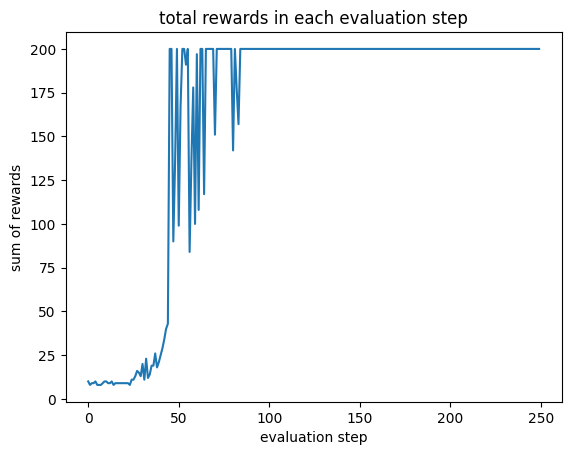

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 1000
STEPS_PER_EPISODE = 200
from tqdm import tqdm

env = gym.make("CartPole-v1")
state = env.reset()
##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
agent_online = SACAgent(env,replay_buffer=None, use_cql=False, offline=False)
evaluate_score = np.zeros(int(EPISODES_PER_RUN/TRAINING_EVALUATION_RATIO,))
counter_score = 0
d = 0
for episode_number_for in tqdm(range(EPISODES_PER_RUN)):
  state = env.reset()
  total_reward = 0 # in q learning we used a discount factor 0.99 but here because we want to see how long episodes can be we just sum rewards normally
  done = False

  if((episode_number_for % TRAINING_EVALUATION_RATIO) == 0):
    evaluation_episode = True

  else:
    evaluation_episode = False
  counter_step = 0
  for i in range(STEPS_PER_EPISODE):

    action = agent_online.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    if evaluation_episode:
      total_reward += reward
    if not evaluation_episode:
      agent_online.train_on_transition(state, action, next_state, reward, done)


    counter_step = counter_step + 1
    state = next_state
    if done:

      break
  if evaluation_episode:
        evaluate_score[counter_score] = total_reward
        counter_score += 1
env.close()


plt.plot(range(counter_score),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step')


##########################################################

we run again to see if it is stable or not

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 1000/1000 [26:47<00:00,  1.61s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step')

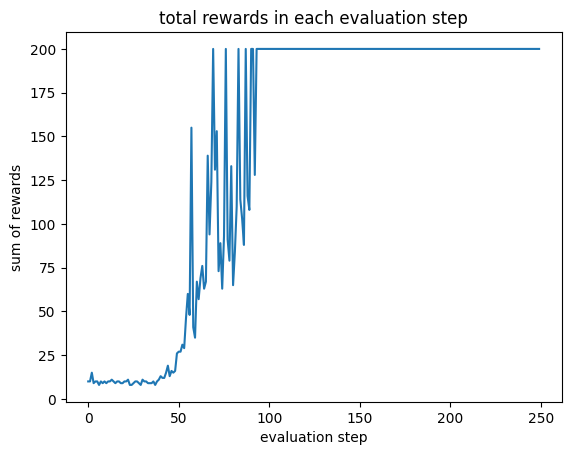

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 1000
STEPS_PER_EPISODE = 200
from tqdm import tqdm

env = gym.make("CartPole-v1")
state = env.reset()
##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
agent_online = SACAgent(env,replay_buffer=None, use_cql=False, offline=False)
evaluate_score = np.zeros(int(EPISODES_PER_RUN/TRAINING_EVALUATION_RATIO,))
counter_score = 0
d = 0
for episode_number_for in tqdm(range(EPISODES_PER_RUN)):
  state = env.reset()
  total_reward = 0 # in q learning we used a discount factor 0.99 but here because we want to see how long episodes can be we just sum rewards normally
  done = False

  if((episode_number_for % TRAINING_EVALUATION_RATIO) == 0):
    evaluation_episode = True

  else:
    evaluation_episode = False
  counter_step = 0
  for i in range(STEPS_PER_EPISODE):

    action = agent_online.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    if evaluation_episode:
      total_reward += reward
    if not evaluation_episode:
      agent_online.train_on_transition(state, action, next_state, reward, done)


    counter_step = counter_step + 1
    state = next_state
    if done:

      break
  if evaluation_episode:
        evaluate_score[counter_score] = total_reward
        counter_score += 1
env.close()


plt.plot(range(counter_score),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step')


##########################################################

as we can see, in online learning it learns really fast and have good results and it is also very stable (in each run it reaches good result)

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

we use two different approches, in first approch in each epoch run, we train on whole dataset.
another approch is to just train one batch in each epoch, this result in more noisy but we will see in CQL part it results in much better result.
for first method (using all data in each epoch) we have:

100%|██████████| 200/200 [26:37<00:00,  7.99s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

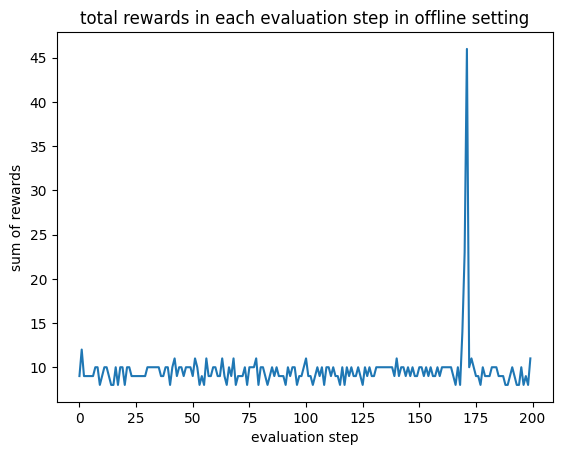

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=False, offline=True)
evaluate_score = np.zeros((NUM_EPOCHS,))
buffer_size = offline_buffer.get_size()
for epochs in tqdm(range(NUM_EPOCHS)):
  start_indics = np.arange(0,buffer_size,100)
  np.random.shuffle(start_indics)
  for j in range(len(start_indics)):
     agent_offline.train_networks(batch_deterministic_start = int(start_indics[j]))
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



in another run(with another replay memory, in which it learn slower to do optimal behavior so in offline setting we had more negative sample) we have:

100%|██████████| 200/200 [47:38<00:00, 14.29s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

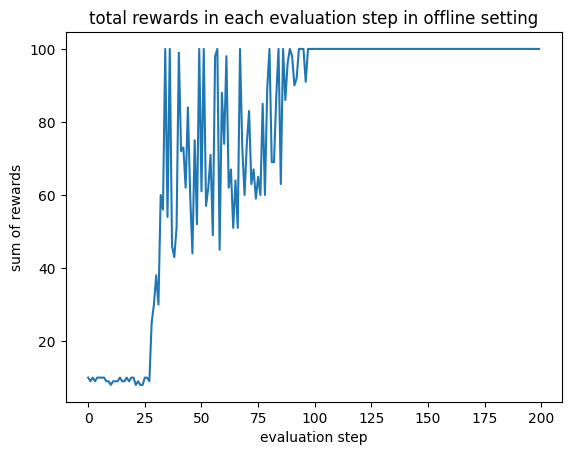

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=False, offline=True)
evaluate_score = np.zeros((NUM_EPOCHS,))
buffer_size = offline_buffer.get_size()
for epochs in tqdm(range(NUM_EPOCHS)):
  start_indics = np.arange(0,buffer_size,100)
  np.random.shuffle(start_indics)
  for j in range(len(start_indics)):
     agent_offline.train_networks(batch_deterministic_start = int(start_indics[j]))
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



as we can see, in first run it couldn't learn well, but in second it learned well, but overall we can see simple offline learning is very unstable
now lets use second describe method to train in offline setting (train only on batch in each epoch)

100%|██████████| 793/793 [00:20<00:00, 39.60it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

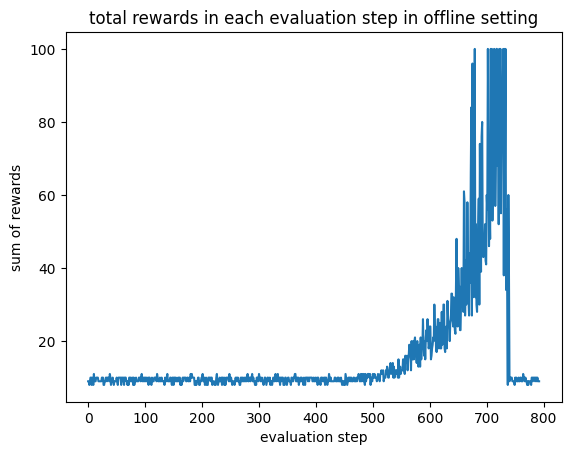

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=False, offline=True)
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



we can see that sometimes in offline, even when it only see all data just once can learn good result but in the end it fall off really bad and it is because of overestimation! we will see that in next part using cql will help us to overcome this problem.
also other thing is that it is that it is very unstable as we can see in next run bellow:

100%|██████████| 793/793 [00:18<00:00, 43.96it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

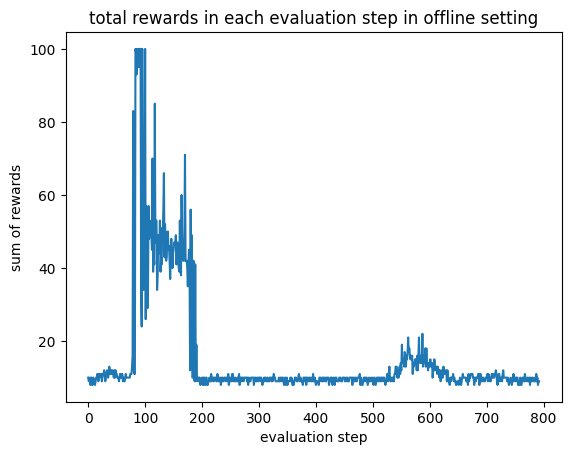

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=False, offline=True)
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

like previous part, we use two approches to train our agent
in first method in each epoch we train on all data (all batches) results are shown bellow:

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 200/200 [25:09<00:00,  7.55s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

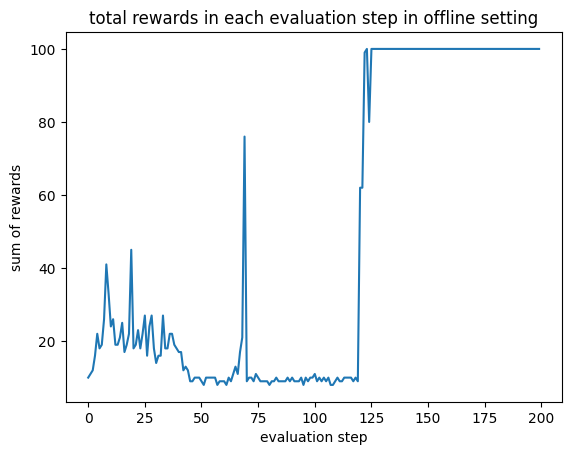

In [ ]:

RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
evaluate_score = np.zeros((NUM_EPOCHS,))
buffer_size = offline_buffer.get_size()
for epochs in tqdm(range(NUM_EPOCHS)):
  start_indics = np.arange(0,buffer_size,100)
  np.random.shuffle(start_indics)
  for j in range(len(start_indics)):
     agent_offline.train_networks(batch_deterministic_start = int(start_indics[j]))
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')


but in this approch we can see that it isn't stable all the time as we can see below:

100%|██████████| 200/200 [26:41<00:00,  8.01s/it]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

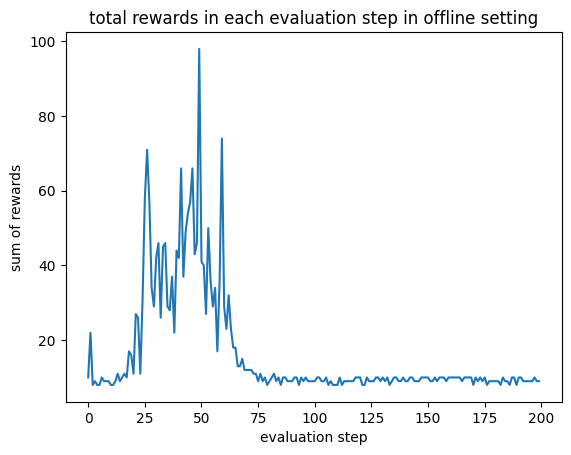

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
evaluate_score = np.zeros((NUM_EPOCHS,))
buffer_size = offline_buffer.get_size()
for epochs in tqdm(range(NUM_EPOCHS)):
  start_indics = np.arange(0,buffer_size,100)
  np.random.shuffle(start_indics)
  for j in range(len(start_indics)):
     agent_offline.train_networks(batch_deterministic_start = int(start_indics[j]))
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')


but if we use second approch (train only one batch in each epoch) we achive very good results:

100%|██████████| 793/793 [00:20<00:00, 38.41it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

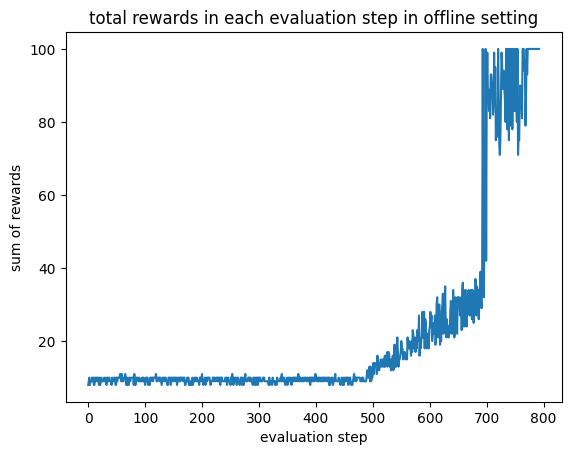

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



100%|██████████| 793/793 [00:20<00:00, 39.60it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

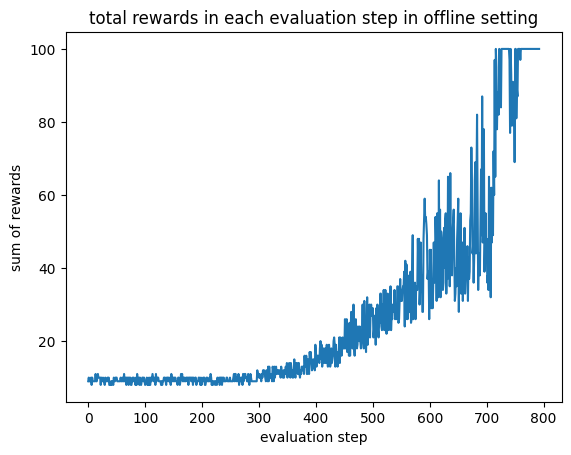

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



we also try other values for tradeof_factor parameter

for tradeof_factor = 1 we have:



100%|██████████| 793/793 [00:19<00:00, 41.61it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

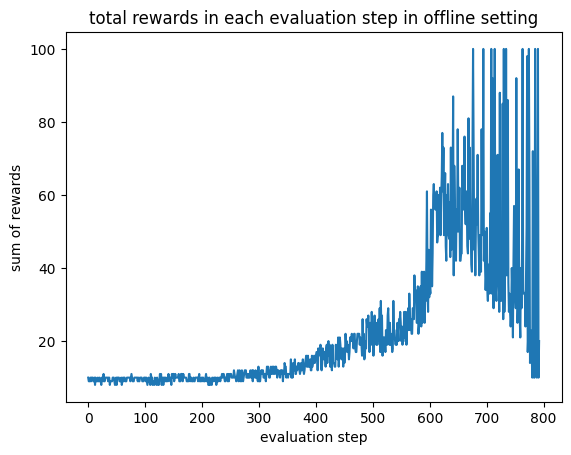

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
agent_offline.TRADEOFF_FACTOR = 1
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



for tradeof_factor = 3 we have:


100%|██████████| 793/793 [00:20<00:00, 39.55it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

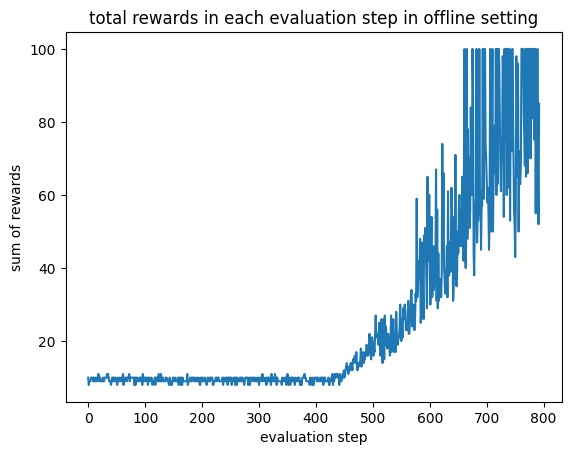

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
agent_offline.TRADEOFF_FACTOR = 3
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



and for 10

100%|██████████| 793/793 [00:25<00:00, 31.32it/s]


Text(0.5, 1.0, 'total rewards in each evaluation step in offline setting')

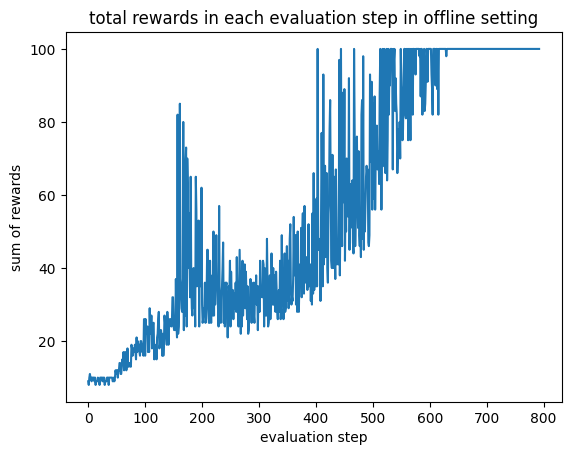

In [ ]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
offline_buffer = agent_online.replay_buffer
evaluation_episode = True
agent_offline =  SACAgent(env,replay_buffer=offline_buffer, use_cql=True, offline=True)
agent_offline.TRADEOFF_FACTOR = 10
buffer_size = offline_buffer.get_size()
start_indics = np.arange(0,buffer_size,100)
np.random.shuffle(start_indics)
NUM_EPOCHS = len(start_indics)
evaluate_score = np.zeros((NUM_EPOCHS,))
counter_batch = 0
for epochs in tqdm(range(NUM_EPOCHS)):


  agent_offline.train_networks(batch_deterministic_start = int(start_indics[counter_batch]))
  counter_batch += 1
  if counter_batch >= len(start_indics):
    counter_batch = 0
  state = env.reset()
  done = False
  total_reward = 0
  for i in range(EPISODES_PER_RUN):

    action = agent_offline.get_next_action(state, evaluation_episode)
    next_state, reward, done, truncated = env.step(action)
    total_reward += reward



    state = next_state
    if done:

      break

  evaluate_score[epochs] = total_reward


plt.plot(range(NUM_EPOCHS),evaluate_score)
plt.xlabel('evaluation step')
plt.ylabel('sum of rewards')
plt.title('total rewards in each evaluation step in offline setting')



we discuss effect of TRADEOFF_FACTOR in next part

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?
in online agent, after updating policy we run it and collect data based on it, so we get direct feedback from system so if our policy learn something wrong we can correct it easily, but on offline setting we don't have direct feedback so there is no correcting agents wrongs directly so offline setting is very unstable (because network initialize randomly, with same data we can't garantee their always converge to same answere!)

❓ Which one is better: offline SAC or conservative SAC?
as we can see, conservative SAC is better and much more stable, because in online setting agent learns very fast(problem is very easy to solve) we don't have that much negative sample so it is very easy for our model to overestimate and give all action hight Q value but when using conservative SAC we overcome this problem and achive good result

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?
with TRADEOFF_FACTOR, we control effect of CQL loss part and standard SAC loss function ( the bigger TRADEOFF_FACTOR gets, the bigger emphazie on CQL loss we put) so by increasing it, we pushing down all Q values that aren't seen in dataset and push up data that we seen, so it becomes more like imitation learning so if TRADEOFF_FACTOR it's not garanteed that we get good result and it only works when we exactly saw that situation in dataset, and when TRADEOFF_FACTOR is low we have overestimation problem that we saw in simple SAC agent, so when we increase TRADEOFF_FACTOR, first model becomes more stable and can learn to perform good until it reaches a good balance (around TRADEOFF_FACTOR = 5 to 7) but when we increase it more, the behavior becomes more noisy until it drops and doesn't learn to perform task well